# Team health survey

## Leverage the edmondson library

In [1]:
(ns google-sheets-example
  (:require [edmondson.google-api :as api]
            [edmondson.survey-analysis :as analysis]
            [edmondson.survey-model :as model]
            [edmondson.config :as cfg]
            [edmondson.reports :as reports]
            [clojure.string :as str]))

:OK

:OK

## Defining the Likert scale for scoring questions

In [2]:
(def agree-disagree-7-pt-params ;; default scoring for 7pt Likert scale
  {"Strongly agree" 7
   "Agree" 6
   "Somewhat agree" 5
   "Neutral" 4
   "Somewhat disagree" 3
   "Disagree" 2
   "Strongly Disagree" 1})

(defn default-scale "identity scoring transformation" [a _] a)

(defn negative-scale
  "Scoring transform for reverse-scored likert questions"
  [a likert-scale]
  (- (inc (count likert-scale)) a))

:OK

:OK

## Survey model
This section defines the survey question and how we intend to score them.

For psychological safety and generative culture, we use a 7-pt Likert scale with some questions reverse scored.

In [3]:
(def example-model
  {
   "Psychological safety"
   {:scoring agree-disagree-7-pt-params ;; default scoring with 7p likert scale
    :scale default-scale ;; default scale is normal scale
    :questions [["I worry that mistakes will be held against me."
                 ;; since Strongly agree is quite bad here.
                 ;; this questions is scored in reverse, so we override default scale:
                 {:scale negative-scale}]
                "I am able to bring up problems and tough issues." ;; defaults
                ["People in the team sometimes reject others for being different."
                 {:scale negative-scale}]
                "It is safe to take a risk within the team."
                ["I find it difficult to ask other members of the team for help."
                 {:scale negative-scale}]
                "No one in the team would deliberately act in a way that undermines my efforts."
                "My unique skills and talents are valued and utilized in this team."]}

   "Generative culture"
   {:scoring agree-disagree-7-pt-params
    :scale default-scale
    :questions ["No-one is punished for delivering news of failure or other bad news."
                "Responsibilities are shared (you hear mostly \"this is our responsibility\" vs \"this is not my responsibility\")"
                "Cross functional and cross-team collaboration is encouraged and rewarded."
                "People on our team welcome new ideas, regardless of source and seniority."
                "Failure causes inquiry (failures are investigated, not ignored or hidden)"
                "Failures are treated primarily as opportunities to improve the system, processes or team."
                "New information is actively sought out."]}

   "Psychological safety domains"
   {:groups ["For you personally, choose the three topics which you find the most uncomfortable, or where you'd least want to bring up your concerns or have a conversation about."]}
   ;; This allows us to group responses based on how people check
   ;; boxes in this question. Also makes it easier to count which
   ;; boxes get the most checks.

   "Open-ended feedback"
   ;; These are not analyzed quantitatively
   {:verbatims ["If you could change one team process, or one thing about how the team works, what would you change and why?"
                "What is something the team does really well? Something that would make you very disappointed if the team stopped doing or something that makes you proud to be part of the team."]}

   })

(def model-index
  (model/index-questions example-model))

:OK

:OK

## Fetch and score the responses
This will take a bit of time to evaluate since it calls the Google API.

Note that the kernel will store a token so you want to delete the kernel after your session.

In [4]:
;; Example of usage.
;; Given https://docs.google.com/spreadsheets/d/1QkBeMNGfsHHga85c-UsLAwnpmz7QyhvFK_n31CzDe7c/edit?usp=sharing
;; Define:

(def spreadsheetId "1QkBeMNGfsHHga85c-UsLAwnpmz7QyhvFK_n31CzDe7c")
(def tab-name "Form Responses 1")
(def spreadsheet-range (str tab-name "!B:R")) ;; this is where the answers are

:OK

:OK

## Note: change this path to be the path to your credentials.json and token directory

In [5]:
(binding [cfg/*credentials-json-path-override* "/Users/krukow/code/github/edmondson/credentials.json"]
    (def survey-results (api/eval-range {:token-directory "/Users/krukow/code/github/edmondson/tokens" }
                                        spreadsheetId spreadsheet-range)))

(def survey-questions (first survey-results)) ;; first row of sheet are the questions
(def survey-answers (rest survey-results)) ;; first row of sheet are the questions


(def normalized-responses
  (api/normalize-responses survey-questions survey-answers))

(def scored-responses (analysis/score-responses
                       model-index
                       normalized-responses))

(def aggregate-results
  (analysis/aggregate-scores example-model scored-responses))
;

## Time to review the results
Results of 40 and above is considered very good for psychological safety.

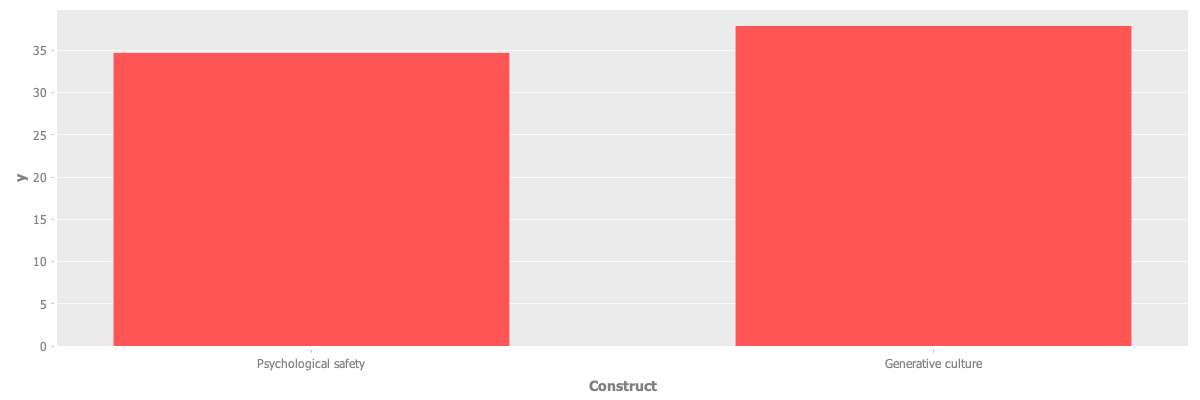

In [6]:
(use '(incanter core stats charts io))
(let [res (select-keys aggregate-results ["Psychological safety", "Generative culture"])]
    (-> (bar-chart (keys res)
                   (map #(get-in % [:construct-stats :score-total]) (vals res))
                  :x-label "Construct" :y-label "y")
        (.createBufferedImage 1200 400)))


In [7]:
(comment
  (->> (drop 1 (map :groups scored-responses))
       (map #(get % "For you personally, choose the three topics which you find the most uncomfortable, or where you'd least want to bring up your concerns or have a conversation about."))
       (map #(str/split % #","))
       (map frequencies)
       (apply (partial merge-with +))
       (sort-by second)
       reverse)

  )

 ;(clojure.pprint/pprint scored-survey-results

;; (def scored-responses-managers (group-by (comp :DEMO_MANAGER :groups)
;;                                          scored-responses))

;; (def grouped-scored-responses (group-by (comp :groups) scored-responses))


;; (comment (clojure.pprint/pprint (get (analysis/aggregate-scores (get scored-responses-managers "No"))
;;                                      "Psychological Safety")))


;; (clojure.pprint/pprint scored-survey-results)

nil